## 1. numpy의  polyfit으로 회귀 분석하기

* pip install pandas_datareader
* pip install prophet --use-feature=2020-resolver --user
* pip install pystan==2.19.1.1
* pip install cython
* pip install ploty

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet
from datetime import datetime

In [5]:
#matplot 폰트 문제 해결

from matplotlib import font_manager, rc
plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

In [6]:
pinkwink_web = pd.read_csv("C:/Users/Yeji/Downloads/08. PinkWink Web Traffic.csv", encoding = "utf-8", thousands = ',',
                          names = ['date', 'hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


<AxesSubplot:xlabel='date'>

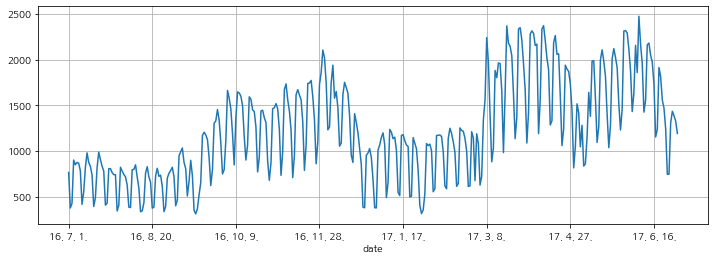

In [7]:
#2016년 7월 1일부터 217년 6월 16일까지 유입량
pinkwink_web['hit'].plot(figsize=(12,4), grid=True)

주기를 파악하기 어렵다

In [9]:
time = np.arange(0, len(pinkwink_web)) #시간축 생성
traffic = pinkwink_web['hit'].values #웹트래픽 자료 저장

fx = np.linspace(0, time[-1], 1000)

In [10]:
#에러 함수 정의

def error(f, x, y):
    return np.sqrt(np.mean(f(x)-y)**2)

In [11]:
fp1 = np.polyfit(time, traffic, 1)
f1 = np.poly1d(fp1)

f2p = np.polyfit(time, traffic, 2)
f2 = np.poly1d(f2p)

f3p = np.polyfit(time, traffic, 3)
f3 = np.poly1d(f3p)

f15p = np.polyfit(time, traffic, 15)
f15 = np.poly1d(f15p)

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))

3.986826089963521e-14
8.970358702417922e-14
3.4884728287180807e-13
1.8685903161322007e-06


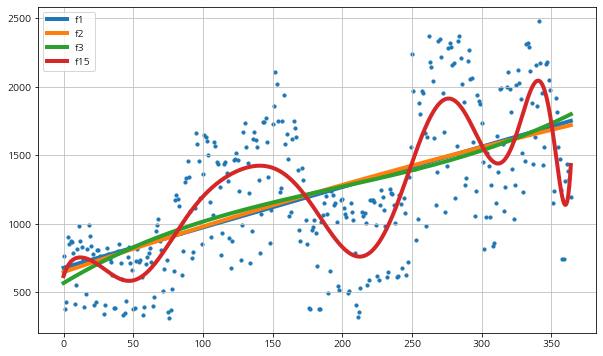

In [12]:
plt.figure(figsize = (10,6))
plt.scatter(time, traffic, s=10)

plt.plot(fx, f1(fx), lw=4, label='f1')
plt.plot(fx, f2(fx), lw=4, label='f2')
plt.plot(fx, f3(fx), lw=4, label='f3')
plt.plot(fx, f15(fx), lw=4, label='f15')

plt.grid(True, linestyle='-', color='0.75')
plt.legend(loc=2)
plt.show()

1차, 2차, 3차는 큰 차이가 없으나 15차는 과적합일 수 있음

## 2. Prophet 모듈을 이용한 forecast 예측

In [13]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace=True)
df['ds'] = pd.to_datetime(df['ds'], format="%y. %m. %d.") #날짜 선언
del df['date']

m = Prophet(yearly_seasonality=True)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [14]:
#60일간 데이터 예측
future = m.make_future_dataframe(periods=60)
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [15]:
#예측된 데이터 forecast에 저장
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,918.675713,710.807156,1113.990644
421,2017-08-26,503.601977,298.335641,706.302403
422,2017-08-27,636.140634,422.240984,846.506406
423,2017-08-28,1188.778910,985.468917,1403.664055
424,2017-08-29,1224.659858,1014.056233,1446.742491


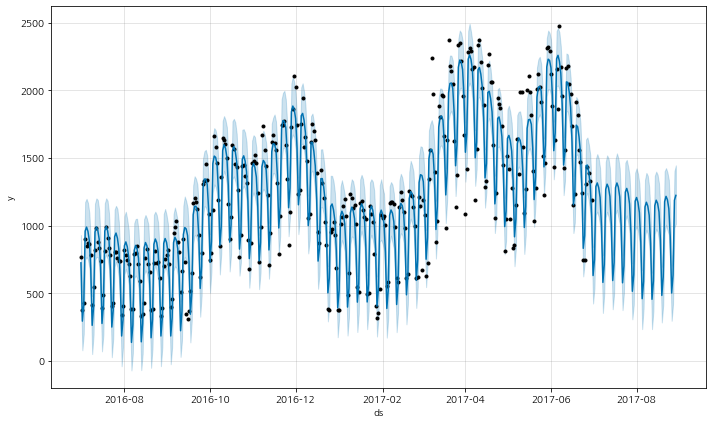

In [17]:
m.plot(forecast);

약 두 달간의 데이터 예측 결과

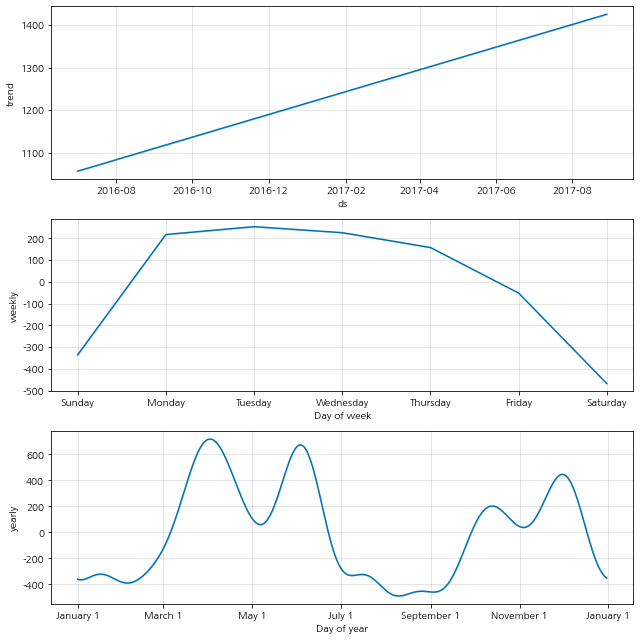

In [19]:
m.plot_components(forecast);

전체적인 경향은 직선으로 표현되나, 주별로 보았을 때, 월, 화가 가장 방문수가 많고 토, 일은 매우 적음을 알 수 있다.

## 3. Seasonal 시계열 분석으로 주식 데이터 분석하기

* pip install yfinance --upgrade --no-cache-dir

In [29]:
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

start_date = '1990-1-1' 
end_date = '2017-6-30' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,7404.519043,7665.241699,7300.229980,7665.241699,5367.460449,636300
2000-01-05,7404.519043,7404.519043,7248.085449,7248.085449,5075.353027,686100
2000-01-06,7331.516602,7519.236816,6935.218262,6935.218262,4856.273438,379000
2000-01-07,6987.362793,7143.796387,6778.785156,6778.785156,4746.733398,701400
2000-01-10,6841.358398,7102.081055,6810.071777,7091.651855,4965.812988,1076700


<AxesSubplot:xlabel='Date'>

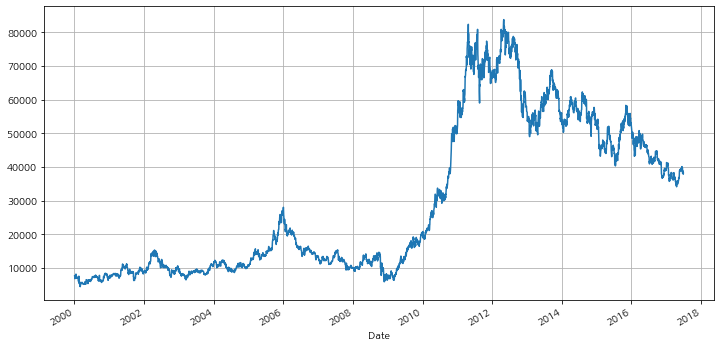

In [30]:
KIA['Close'].plot(figsize=(12,6), grid=True) #종가기준 그래프 그림

KIA의 2003년 1월 1일부터 2017년 6월 30일까지 주가정보를 나타낸 그래프이다. 2010년부터 12년까지 상승했으나 그 이후 전반적으로 하락하고 있다.

In [40]:
KIA_trunc = KIA[:'2016-12-31']
KIA_trunc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-23,38700.0,39350.0,38650.0,39100.0,33386.183594,1070783
2016-12-26,39100.0,39350.0,38850.0,39000.0,33300.796875,465612
2016-12-27,39050.0,39700.0,39050.0,39500.0,33727.730469,879686
2016-12-28,38600.0,39100.0,38600.0,38950.0,34210.808594,662314
2016-12-29,38700.0,39400.0,38700.0,39250.0,34474.304688,586340


In [34]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']
df.head()

,ds,y
0,2000-01-04,7665.241699
1,2000-01-05,7248.085449
2,2000-01-06,6935.218262
3,2000-01-07,6778.785156
4,2000-01-10,7091.651855


In [41]:
m = Prophet(daily_seasonality=True)
m.fit(df);

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [42]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
4661,2017-12-25
4662,2017-12-26
4663,2017-12-27
4664,2017-12-28
4665,2017-12-29


In [43]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4661,2017-12-25,36429.300002,28091.890416,44801.160915
4662,2017-12-26,36474.406855,28087.515384,45043.705210
4663,2017-12-27,36432.420072,28440.379410,45083.833788
4664,2017-12-28,36392.088207,27844.985199,45102.363659
4665,2017-12-29,36334.392692,27838.753179,44794.597859


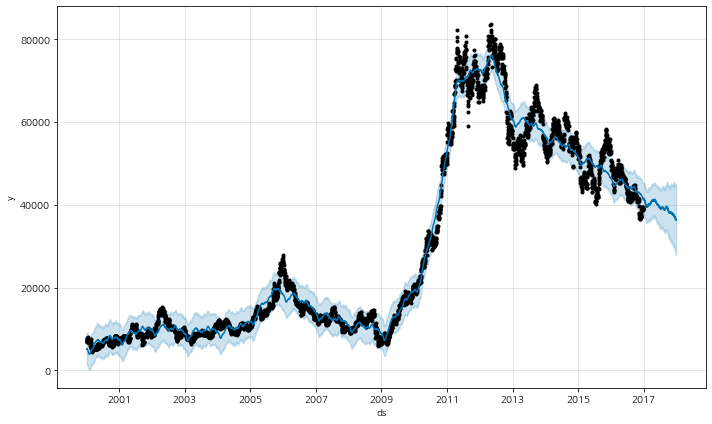

In [44]:
m.plot(forecast);

뒷부분 예측 결과가 비슷해보인다.

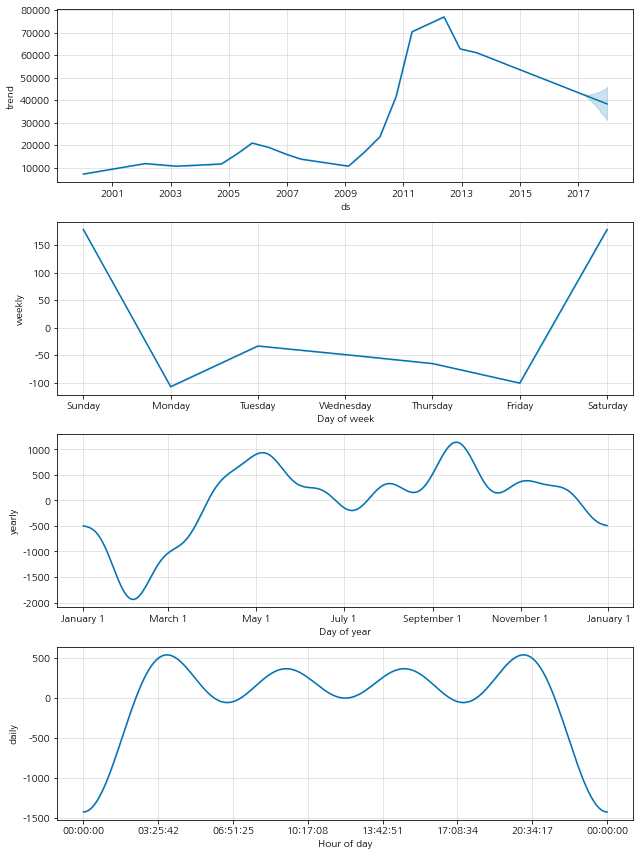

In [45]:
m.plot_components(forecast);

전체적인 경향은 하락세를 띄고 있으며, 주별로 살펴보았을 때는 장이 서지 않는 토요일, 일요일은 제외하고는 화요일이 가장 높은 주가를 유지함을 볼 수 있다. 월별로는 2월이 가장 낮은 주가를 기록함을 보여준다.

[*********************100%***********************]  1 of 1 completed


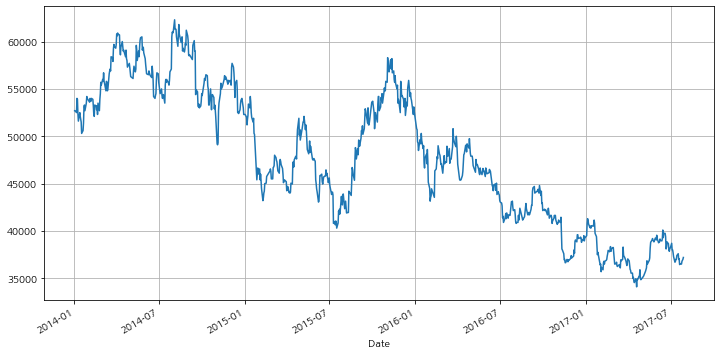

In [46]:
# 다른 날짜로 예측
start_date = '2014-1-1' 
end_date = '2017-7-31' 
KIA = data.get_data_yahoo('000270.KS', start_date, end_date)
KIA['Close'].plot(figsize=(12,6), grid=True);

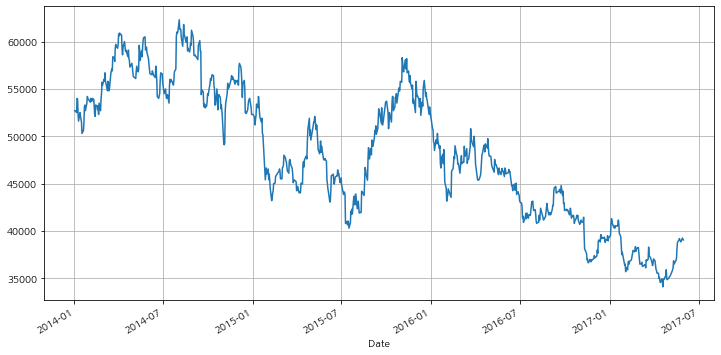

In [47]:
#예측용으로 사용할 데이터

KIA_trunc = KIA[:'2017-05-31']
KIA_trunc['Close'].plot(figsize=(12,6), grid=True);

In [50]:
df = pd.DataFrame({'ds':KIA_trunc.index, 'y':KIA_trunc['Close']})
df.reset_index(inplace=True)
del df['Date']

In [51]:
m = Prophet(daily_seasonality=True)
m.fit(df);

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [52]:
future = m.make_future_dataframe(periods=61)
future.tail()

,ds
897,2017-07-27
898,2017-07-28
899,2017-07-29
900,2017-07-30
901,2017-07-31


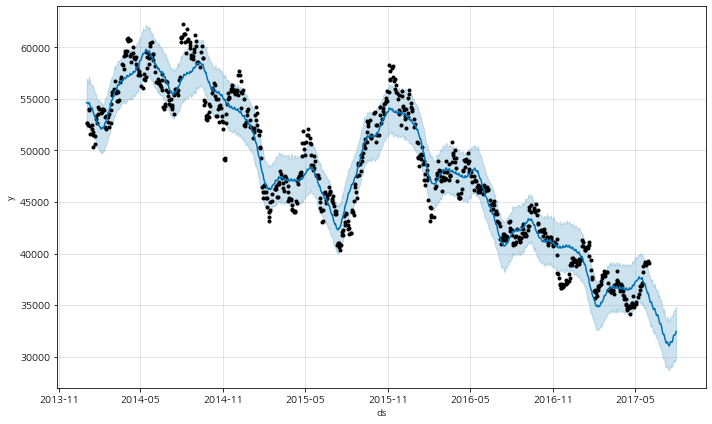

In [54]:
forecast = m.predict(future)
m.plot(forecast);

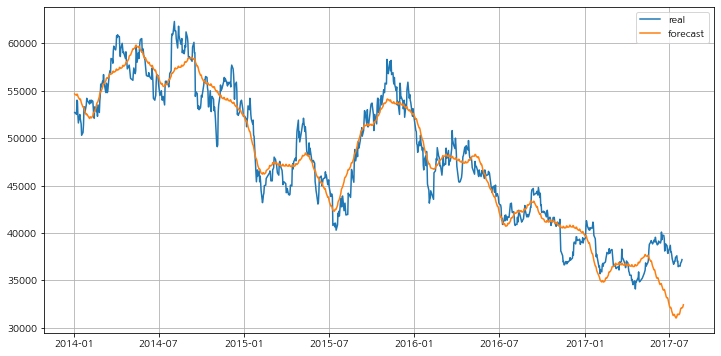

In [55]:
#실제 데이터와 비교하기

plt.figure(figsize=(12,6))
plt.plot(KIA.index, KIA['Close'], label = 'real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

예측데이터와 실제 데이터가 차이가 있지만 대략적인 모양은 비슷함을 보여준다.

## 4. Growth Model과 Holiday Forecast
#### 4-1 Growth Model

In [56]:
df = pd.read_csv("c:/Users/Yeji/Downloads/08. example_wp_R.csv")
df['y'] = np.log(df['y'])

In [57]:
df['cap'] = 8.5

In [58]:
m = Prophet(growth = 'logistic', daily_seasonality=True)
m.fit(df)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


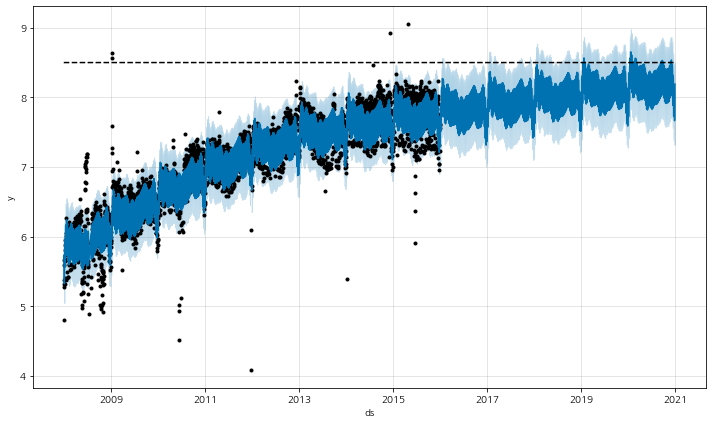

In [60]:
future = m.make_future_dataframe(periods=1826)
future['cap'] = 8.5
fcst = m.predict(future)
m.plot(fcst);

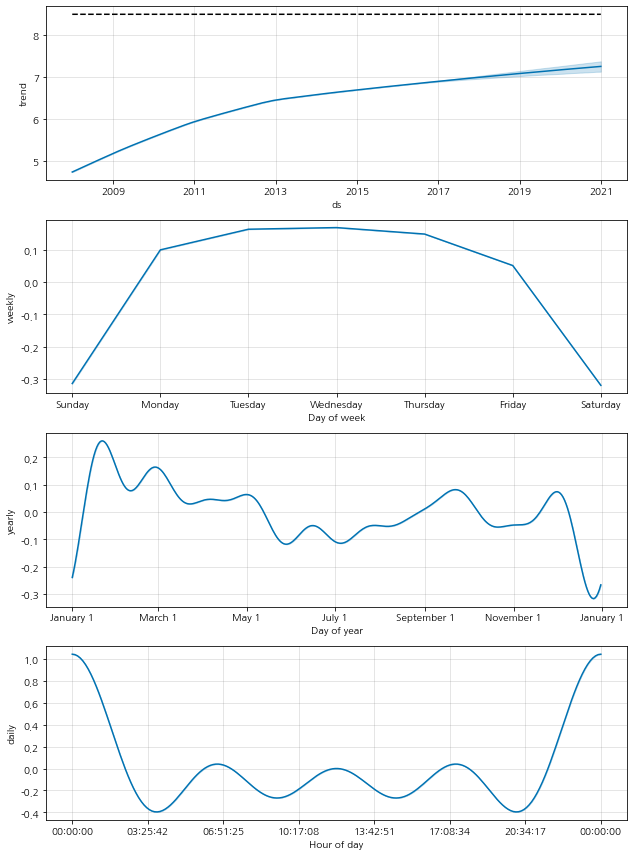

In [61]:
forecast = m.predict(future)
m.plot_components(forecast);

#### 4-2 Holiday Model

In [63]:
df = pd.read_csv("c:/Users/Yeji/Downloads/08. example_wp_peyton_manning.csv")
df['y'] = np.log(df['y'])
m = Prophet(daily_seasonality=True)
m.fit(df)
future = m.make_future_dataframe(periods=366)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


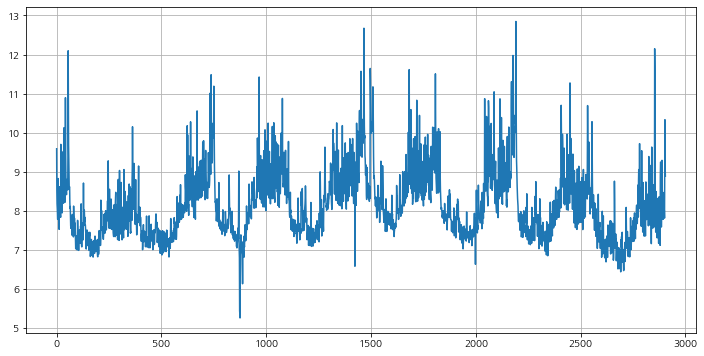

In [64]:
df.y.plot(figsize=(12,6), grid = True);

In [65]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [66]:
m = Prophet(holidays=holidays, daily_seasonality=True)
forecast = m.fit(df).predict(future)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [67]:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.226268,1.199781
2191,2014-02-03,1.904286,1.464876
2532,2015-01-11,1.226268,0.000000
2533,2015-01-12,1.904286,0.000000
2901,2016-01-17,1.226268,0.000000
2902,2016-01-18,1.904286,0.000000
2908,2016-01-24,1.226268,0.000000
2909,2016-01-25,1.904286,0.000000
2922,2016-02-07,1.226268,1.199781
2923,2016-02-08,1.904286,1.464876


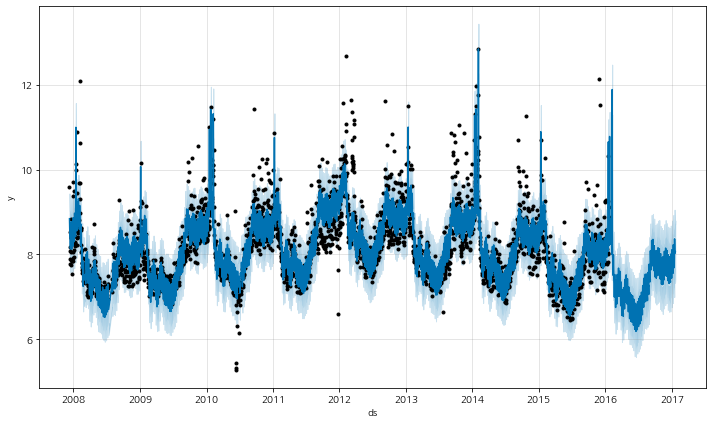

In [68]:
m.plot(forecast);

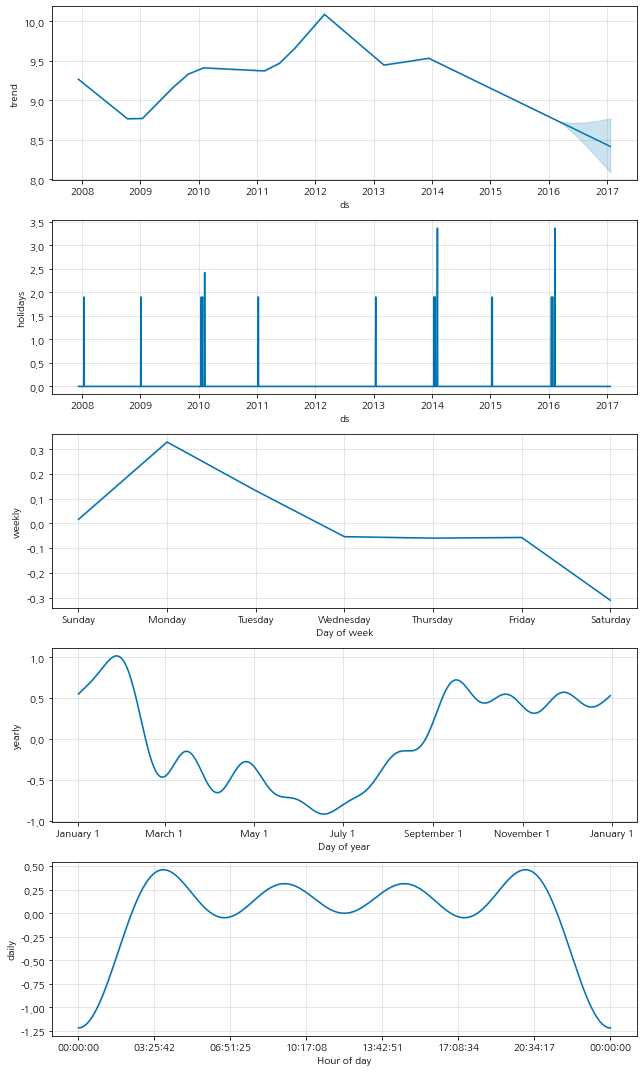

In [70]:
m.plot_components(forecast);